## CSCA5622 Final Project - Bank Marketing

Github repository: https://github.com/jfadia/csca5622-final-project

Author: Jai Fadia

## Part 1: Project topic
The data used in this project comes from University of California Irvine's ML repository. It will be imported into this notebook via the `ucimlrepo` package developed by the university.

### Background
The data used in this project comes from direct outbound phone marketing campaigns undertaken by a Portugese bank. The goal of these campaigns was to sell the customer a bank term deposit.

In a machine learning problem context: given a set of dependent variables, predict if the customer would agree to purchasing a bank term deposit (independent variable). This aligns with a supervised learning approach.

### Goals
The goal of this project is to develop a supervised learning model that can predict if a customer would be willing to purchase a bank term deposit. This type of problem is important in an outbound call center context because limited human resources make it important to prioritize customers who are more likely to make a purchase.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import ucimlrepo
import pandas as pd
import numpy as np
from tabulate import tabulate
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import imblearn
%matplotlib inline

## Part 2: Data

### APA Citation:
UCI Machine Learning Repository. (n.d.). Archive.ics.uci.edu.

    https://archive.ics.uci.edu/dataset/222/bank+marketing

In [2]:
data = ucimlrepo.fetch_ucirepo(id=222)

X = data.data.features
y = data.data.targets

In [3]:
data["variables"]

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,None,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",None,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",None,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",None,no
4,default,Feature,Binary,None,has credit in default?,None,no
5,balance,Feature,Integer,None,average yearly balance,euros,no
6,housing,Feature,Binary,None,has housing loan?,None,no
7,loan,Feature,Binary,None,has personal loan?,None,no
8,contact,Feature,Categorical,None,contact communication type (categorical: 'cell...,None,yes
9,day_of_week,Feature,Date,None,last contact day of the week,None,no


In [4]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN


In [5]:
y.head()

,y
0,no
1,no
2,no
3,no
4,no


In [6]:
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Number of samples: 45211
Number of features: 16


## Part 3: Data cleaning

In [7]:
# first, combine X and y so that any cleaning (ex. dropping rows) maintains the same samples
df = pd.concat([X, y], axis=1)

Independent Variable Cleaning

In [8]:
# the independent variable is stores as "yes" or "no"
# this needs to be converted to 0/1 to be passed into a model

df["y"] = df["y"].apply(lambda x: x == "yes").astype(int)

In [9]:
# check data imbalance across classes
# data is quite imbalanced across classes (~5k yes, ~40k no) and we may need to implement imabalanced
# learning strategies to avoid the model overfitting to "no" simply due to the higher number of rows

print(df["y"].value_counts())

y
0    39922
1     5289
Name: count, dtype: int64


Dependent Variable Cleaning

In [10]:
# handle null values
print(df.isna().sum())

# Some columns have too many null values and should be dropped
df.drop(["poutcome", "contact"], axis=1, inplace=True)

# A few variables are set to NaN where value is unknown -- fix this to use "unknown" since it is a category
df[["job", "education"]] = df[["job", "education"]].fillna("unknown")

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64


In [11]:
print(df.isna().sum())

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
y              0
dtype: int64


In [12]:
# drop "duration" as this variable would not be known in advance of the call
df.drop("duration", axis=1, inplace=True)

# convert binary variables from "yes"/"no" to 0/1
df[["default", "housing", "loan"]] = df[["default", "housing", "loan"]].apply(lambda x: x == "yes", axis=1).astype(int)

# add ordinality to month variable
month_map = {m.lower(): i for i, m in enumerate(month_abbr)}
df["month"] = df["month"].apply(lambda x: month_map[x])

# one hot encode categorical variables
df = pd.get_dummies(df, columns=["job", "marital", "education"])

In [13]:
df

,age,default,balance,housing,loan,day_of_week,month,campaign,pdays,previous,...,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
0,58,0,2143,1,0,5,5,1,-1,0,...,False,False,False,False,True,False,False,False,True,False
1,44,0,29,1,0,5,5,1,-1,0,...,True,False,False,False,False,True,False,True,False,False
2,33,0,2,1,1,5,5,1,-1,0,...,False,False,False,False,True,False,False,True,False,False
3,47,0,1506,1,0,5,5,1,-1,0,...,False,False,False,False,True,False,False,False,False,True
4,33,0,1,0,0,5,5,1,-1,0,...,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,11,3,-1,0,...,True,False,False,False,True,False,False,False,True,False
45207,71,0,1729,0,0,17,11,2,-1,0,...,False,False,False,True,False,False,True,False,False,False
45208,72,0,5715,0,0,17,11,5,184,3,...,False,False,False,False,True,False,False,True,False,False
45209,57,0,668,0,0,17,11,4,-1,0,...,False,False,False,False,True,False,False,True,False,False


### Discussion
I started cleaning my data by addressing null values. Most of these were categorical variables and could not be imputed. I dropped columns with high proportion of null values as it did not make sense to keep them in. I referenced the documentation on the dataset and was able to fill in null values for columns with "unknown" values.

I also dropped the "duration" column as this is not a value that would be known before the outbound call is made. Given that in a business setting we would run this model to generate lists of customers likely to make a purchase before making calls, it does not make sense to include this variable. Although it is possible to feature engineer a variable for the previous call length, we would end up with a lot of null values as not every customer has picked up a call or even been called before.

I converted binary columns with "yes"/"no" values to 0/1 and added ordinality to the month variable.

Finally, I one-hot-encoded categorical variables so that they can be used as part of the model training process.

## Part 4: Exploratory data analysis

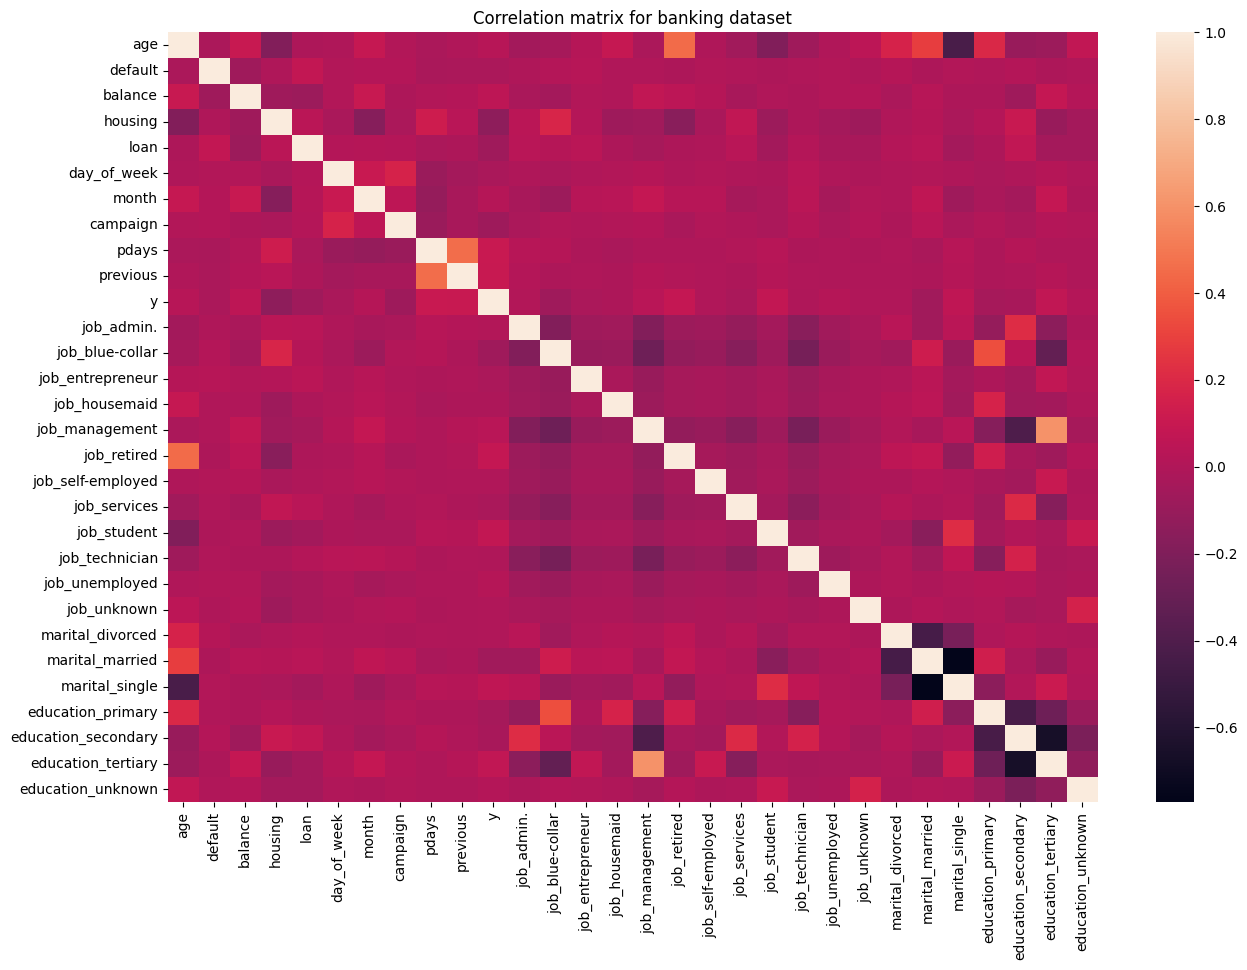

In [14]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr())
plt.title("Correlation matrix for banking dataset")
plt.show()

Observations:
- Target variable is negatively correlated with housing, meaning that customers with a housing loan are less likely to purchase a term deposit
- Target variable has correlation with marital status (single) and education (tertiary), suggesting that people who are single with higher education are more likely to purchase a term deposit
- A lot of the relatively higher/lower correlations are from noise generated by categorical variables so not worth overanalyzing

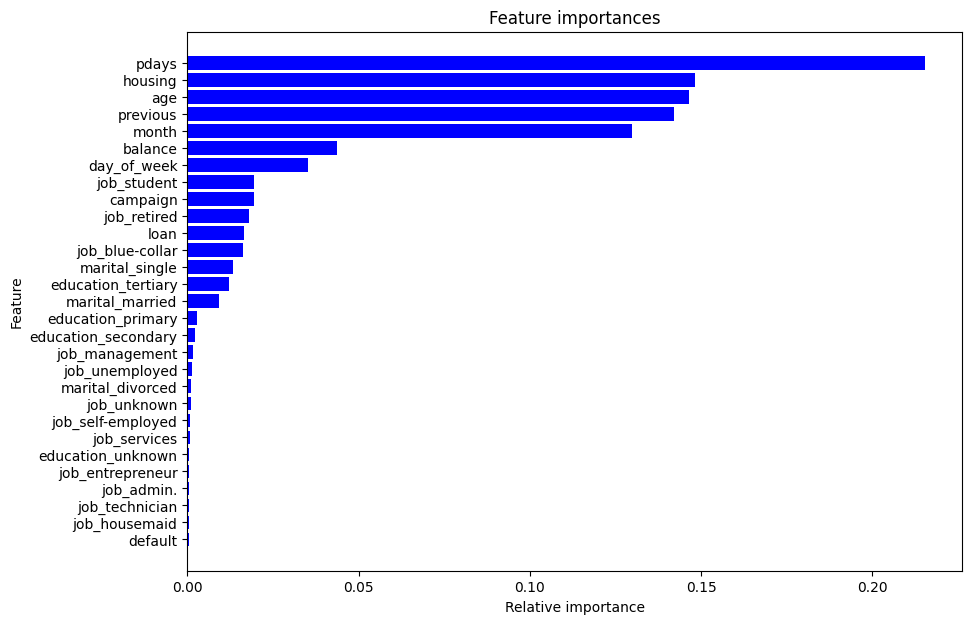

In [15]:
# analyze feature importance by using Random Forest Classifier
# low max depth, higher min samples split as I don't want the model to overfit in this feature importance phase
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_split=100, n_jobs=-1)
clf.fit(df.drop("y", axis=1), df["y"])

df_importance = pd.DataFrame.from_dict(
    {
        "feature": df.drop("y", axis=1).columns,
        "importance": clf.feature_importances_
    },
    orient="columns"
)
df_importance.sort_values("importance", ascending=True, inplace=True)

plt.figure(figsize=(10,7))
plt.title("Feature importances")
plt.yticks(range(len(df_importance)), df_importance["feature"])
plt.ylabel("Feature")
plt.xlabel("Relative importance")
plt.barh(range(len(df_importance)), df_importance["importance"], color="b", align="center")
plt.show()

Observations:
- Features closer to the top including pdays, housing, age, previous, month seem to have the highest relative importance according to the RandomForestClassifier and we should probably keep them in
- Day of wweek and whether or not the customer has a loan seem to be important variables
- Job, marital status and education also seem to have some level of importance but only to a certain degree -- not all jobs seem to be related but if we choose to use jobs we would have to keep all of them in

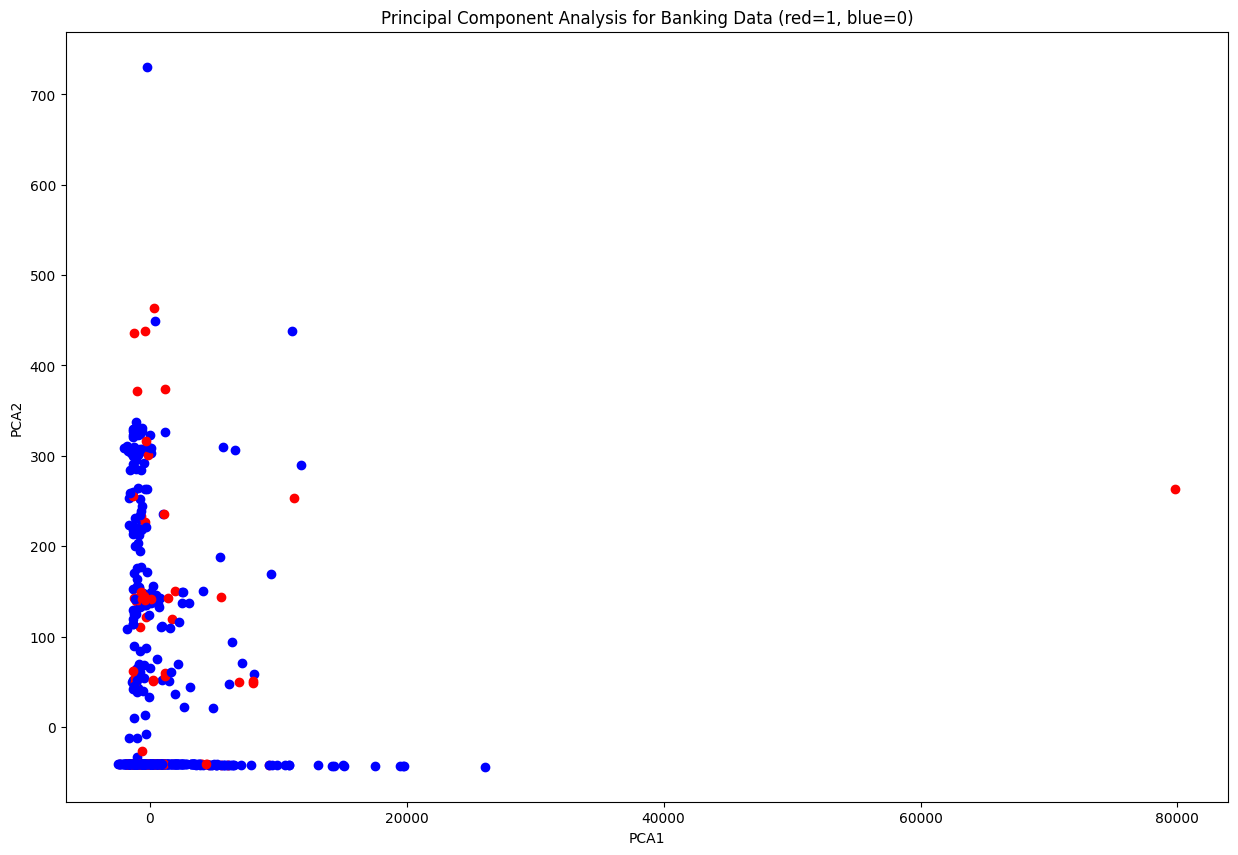

In [16]:
# use principal component analysis to visualize how y labels are distributed
pca = sklearn.decomposition.PCA(n_components=2)
x_transformed = pd.DataFrame(pca.fit_transform(df.drop("y", axis=1), df["y"]))

df_pca = pd.concat([x_transformed, df["y"]], axis=1)
df_pca = df_pca.sample(1000)

plt.figure(figsize=(15,10))
plt.title("Principal Component Analysis for Banking Data (red=1, blue=0)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
for i, row in df_pca.iterrows():
    plt.scatter(row[0], row[1], color="red" if row["y"] == 1 else "blue")
plt.show()

Observations
- Granted that this data is being visualized following dimensionality reduction, we see that the red and blue dots are pretty interspersed and it doesn't look like we can draw a clear line between yes/no
- This could indicate using SVM with the kernel trick to add a dimension to separate out the yes/no data points

## Part 5: Models

In [17]:
# step 1: drop features that were determined to not be as important (below marital_married in above plot)
df.drop(
    [
        "job_services",
        "default", 
        "job_housemaid", 
        "job_admin.", 
        "job_technician", 
        "job_entrepreneur", 
        "education_unknown", 
        "job_self-employed", 
        "job_unknown", 
        "job_unemployed", 
        "marital_divorced", 
        "education_secondary", 
        "job_management"
    ],
    axis=1,
    inplace=True
)

In [18]:
# step 2: fit imbalanced target by oversampling
ros = imblearn.over_sampling.RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(df.drop("y", axis=1), df["y"])

In [19]:
# step 3: split into training and testing set
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_resampled, y_resampled, test_size=0.1)

Testing Different Models

I have chosen to evaluate my models based on `precision score`. This is because the bank likely has limited human resources to be able to make outbound calls so we want to have a high degree of confidence that a customer will purchase a term deposit if we call them. Recall is less important in this case as we would likely be unable to call every customer due to limited resources.

In [20]:
# perform grid search with 5-fold cross validation on training set

def train_and_evaluate_model(clf, params, X_train, X_test, y_train, y_test):
    grid = sklearn.model_selection.GridSearchCV(clf, params, scoring="precision", n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)
    print(f"Best precision score on train set: {grid.best_score_}")
    clf = grid.best_estimator_
    test_score = sklearn.metrics.precision_score(y_test, clf.predict(X_test))
    print(f"Precision score on test set: {test_score}")

    train_accuracy = sklearn.metrics.accuracy_score(y_train, clf.predict(X_train))
    test_accuracy = sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))

    train_recall = sklearn.metrics.recall_score(y_train, clf.predict(X_train))
    test_recall = sklearn.metrics.recall_score(y_test, clf.predict(X_test))

    print(f"Accuracy score: train={train_accuracy}, test={test_accuracy}")
    print(f"Recall score: train={train_recall}, test={test_recall}")

    results = {
        "train_precision": grid.best_score_,
        "test_precision": test_score,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_recall": train_recall,
        "test_recall": test_recall
    }

    return clf, results

In [ ]:
# 1. Test Random Forest Classifier and use GridSearchCV to find the best one

gs_rf_params = {
    "n_estimators": [100, 250, 500],
    "max_depth": [5, 50, 100],
    "min_samples_leaf": [5],
    "min_samples_split": [10, 100]
}
rf, rf_res = train_and_evaluate_model(
    sklearn.ensemble.RandomForestClassifier(),
    gs_rf_params,
    X_train,
    X_test,
    y_train,
    y_test
)

In [ ]:
### not enough computational resources to complete this one so I skipped it ###

# 2. Test SVM and use GridSearchCV to find the best one

gs_svc_params = {
    "C": [0.001, 0.01, 1, 10],
    "kernel": ["rbf", "poly"],
}
svm, svm_res = train_and_evaluate_model(
    sklearn.svm.SVC(),
    gs_svc_params,
    X_train,
    X_test,
    y_train,
    y_test
)

In [ ]:
# 3. Test Bagging Classifier

gs_b_params = {
    "n_estimators": [10, 50, 100],
    "max_samples": [0.25, 0.75],
    "max_features": [0.25, 0.75],
}
b, b_res = train_and_evaluate_model(
    sklearn.ensemble.BaggingClassifier(),
    gs_b_params,
    X_train,
    X_test,
    y_train,
    y_test
)

## Part 6: Analysis of Results

In [ ]:
# results summary
pd.concat([pd.DataFrame.from_dict({"random_forest": rf_res}), pd.DataFrame.from_dict({"bagging_classifier": b_res})], axis=1)

Model takeaways:
- The best model I was able to train used the BaggingClassifier with 0.95 precision on the test set with 0.97 accuracy and 0.99 recall
- The difference between the train/test sets was not very high so I don't believe that my model has overfit
- Using this model to create a shortlist of customers who are most likely to purchase a term deposit would save the bank money by way of not needing to call customers who are unlikely to purchase a term deposit

## Part 7: Discussion & Conclusion


Learning takeaways:
- I found that the most time-consuming part was to clean the data and do EDA -- this was given an already fairly clean dataset
- During experimentation I found that my SVM model took way too long to train and so I cut it short; the large volume of data made it a less-than-optimal model to attempt to train

Areas of improvement:
- There are likely regulations in the banking sector that prevent the use of certain kinds of data for marketing/evaluation of creditworthiness and having more industry context would be helpful
- In a real-world setting this Jupyter notebook would have to be converted to a data pipeline leveraging tools like Airflow, data warehouses (ex. Snowflake), and output an actual list of customers to target that a business stakeholder could use -- next steps would be to design such a system